ARMA (Auto Regression Moving Average)  

In [19]:
import numpy as np 
import pandas as pd  
import matplotlib.pyplot as plt 
import seaborn as sb 
%matplotlib inline 

from statsmodels.tsa.ar_model import AutoReg, ar_select_order  
from sklearn.metrics import mean_squared_error 

In [20]:
# min_tmp = pd.read_csv('../Datasets/daily-min-temperatures.csv', header=0, parse_dates=[0], index_col=0) 
# min_tmp = pd.read_csv('../Datasets/daily-min-temperatures.csv', header=0, parse_dates=[0])  

# min_tmp = pd.read_csv('../Datasets/daily-min-temperatures.csv', header=0, parse_dates=['Date'], date_format=dateparse)   

dateparse = lambda x: pd.to_datetime(x, format='%Y-%m-%d') 
min_tmp = pd.read_csv('../Datasets/daily-min-temperatures.csv', header=0, parse_dates=[0], date_format=dateparse)   
min_tmp 

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7


In [21]:
if not isinstance(min_tmp.index, pd.DatetimeIndex):
    min_tmp.index = pd.to_datetime(min_tmp.index)
    print('Converted index to DateTime format.') 

# min_tmp = min_tmp.asfreq('D') 
# min_tmp = min_tmp.asfreq('H')  
# min_tmp 

Converted index to DateTime format.


# Moving Average -  

Let, actual value (at time t+1) = y  
     predicted value (at time t+1) = y_ + residuals  

y = y_ + residuals  (residual = forecasting error = y - y_)  
Residuals should be white noise with no patterns and seasonality.  

Our model may leave info in residuals too. So to extract the info, we run a forecating model on residuals. The 2nd level model for residuals will identify and capture in the new forecast and this new forecast will be added to our original forecast for better forecast.  

use of AutoReg with moving avg. is also called ARMA method.  

In [22]:
min_tmp['t'] = min_tmp['Temp'].shift(1)        # this column is the lagged column 
min_tmp 

,Date,Temp,t
1970-01-01 00:00:00.000000000,1981-01-01,20.7,NaN
1970-01-01 00:00:00.000000001,1981-01-02,17.9,20.7
1970-01-01 00:00:00.000000002,1981-01-03,18.8,17.9
1970-01-01 00:00:00.000000003,1981-01-04,14.6,18.8
1970-01-01 00:00:00.000000004,1981-01-05,15.8,14.6
...,...,...,...
1970-01-01 00:00:00.000003645,1990-12-27,14.0,14.6
1970-01-01 00:00:00.000003646,1990-12-28,13.6,14.0
1970-01-01 00:00:00.000003647,1990-12-29,13.5,13.6
1970-01-01 00:00:00.000003648,1990-12-30,15.7,13.5


In [23]:
min_tmp['Resid'] = min_tmp['Temp'] - min_tmp['t'] 
min_tmp 

,Date,Temp,t,Resid
1970-01-01 00:00:00.000000000,1981-01-01,20.7,NaN,NaN
1970-01-01 00:00:00.000000001,1981-01-02,17.9,20.7,-2.8
1970-01-01 00:00:00.000000002,1981-01-03,18.8,17.9,0.9
1970-01-01 00:00:00.000000003,1981-01-04,14.6,18.8,-4.2
1970-01-01 00:00:00.000000004,1981-01-05,15.8,14.6,1.2
...,...,...,...,...
1970-01-01 00:00:00.000003645,1990-12-27,14.0,14.6,-0.6
1970-01-01 00:00:00.000003646,1990-12-28,13.6,14.0,-0.4
1970-01-01 00:00:00.000003647,1990-12-29,13.5,13.6,-0.1
1970-01-01 00:00:00.000003648,1990-12-30,15.7,13.5,2.2


Test and Train split - 

In [24]:
# Series data on the Residual values 

train, test = min_tmp.Resid[1: (min_tmp.shape[0]-7)], min_tmp.Resid[(min_tmp.shape[0]-7):]  

In [25]:
train 

1970-01-01 00:00:00.000000001   -2.8
1970-01-01 00:00:00.000000002    0.9
1970-01-01 00:00:00.000000003   -4.2
1970-01-01 00:00:00.000000004    1.2
1970-01-01 00:00:00.000000005    0.0
                                ... 
1970-01-01 00:00:00.000003638    0.7
1970-01-01 00:00:00.000003639   -2.3
1970-01-01 00:00:00.000003640    0.1
1970-01-01 00:00:00.000003641    0.7
1970-01-01 00:00:00.000003642   -3.9
Name: Resid, Length: 3642, dtype: float64

In [26]:
test 

1970-01-01 00:00:00.000003643    2.9
1970-01-01 00:00:00.000003644    1.7
1970-01-01 00:00:00.000003645   -0.6
1970-01-01 00:00:00.000003646   -0.4
1970-01-01 00:00:00.000003647   -0.1
1970-01-01 00:00:00.000003648    2.2
1970-01-01 00:00:00.000003649   -2.7
Name: Resid, dtype: float64

In [27]:
train_y, test_y = min_tmp.Temp[1: (min_tmp.shape[0]-7)], min_tmp.Temp[(min_tmp.shape[0]-7):]  
train_x, test_x = min_tmp.Date[1: (min_tmp.shape[0]-7)], min_tmp.Date[(min_tmp.shape[0]-7):]  

print(f" y_train size : {train_y.shape} \n y_test size : {test_y.shape}") 
print(f" y_train : \n{train_y} \n y_test : \n{test_y}") 

print(f" x_train size : {train_x.shape} \n x_test size : {test_x.shape}") 
print(f" x_train : \n{train_x} \n x_test : \n{test_x}") 

 y_train size : (3642,) 
 y_test size : (7,)
 y_train : 
1970-01-01 00:00:00.000000001    17.9
1970-01-01 00:00:00.000000002    18.8
1970-01-01 00:00:00.000000003    14.6
1970-01-01 00:00:00.000000004    15.8
1970-01-01 00:00:00.000000005    15.8
                                 ... 
1970-01-01 00:00:00.000003638    15.4
1970-01-01 00:00:00.000003639    13.1
1970-01-01 00:00:00.000003640    13.2
1970-01-01 00:00:00.000003641    13.9
1970-01-01 00:00:00.000003642    10.0
Name: Temp, Length: 3642, dtype: float64 
 y_test : 
1970-01-01 00:00:00.000003643    12.9
1970-01-01 00:00:00.000003644    14.6
1970-01-01 00:00:00.000003645    14.0
1970-01-01 00:00:00.000003646    13.6
1970-01-01 00:00:00.000003647    13.5
1970-01-01 00:00:00.000003648    15.7
1970-01-01 00:00:00.000003649    13.0
Name: Temp, dtype: float64
 x_train size : (3642,) 
 x_test size : (7,)
 x_train : 
1970-01-01 00:00:00.000000001    1981-01-02
1970-01-01 00:00:00.000000002    1981-01-03
1970-01-01 00:00:00.000000003    1

Auto-Regression -  

In [28]:
# axlag is less than the number of observations in training data 
# max_lag = max(10, 29, 30, len(train) - 1)  
max_lag = min(10, 29, 30, len(train) - 1)  

# Automatically selecting Optimal number of lagged values 

slct_ord = ar_select_order(train, maxlag=max_lag, ic='aic', seasonal=False) 
optimal_lags = slct_ord.ar_lags 
print(f"optimal number of lags : {optimal_lags}")  

max_optimal_lag = max(optimal_lags) if optimal_lags else 0 
print(f"Max OPtimal lags : {max_optimal_lag}") 

optimal number of lags : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Max OPtimal lags : 10


d:\Machine_Learning_PY\virtl_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)
d:\Machine_Learning_PY\virtl_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)


In [29]:
# train = train[max_optimal_lag:]  
model = AutoReg(train, lags=max_optimal_lag)     
model_fit = model.fit() 
model_fit.summary()  

d:\Machine_Learning_PY\virtl_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  Resid   No. Observations:                 3642
Model:                    AutoReg(10)   Log Likelihood               -8390.385
Method:               Conditional MLE   S.D. of innovations              2.438
Date:                Thu, 30 Oct 2025   AIC                          16804.771
Time:                        20:41:35   BIC                          16879.141
Sample:                    01-01-1970   HQIC                         16831.263
                         - 01-01-1970                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0044      0.040     -0.108      0.914      -0.084       0.075
Resid.L1      -0.3791      0.017    -22.883      0.000      -0.412      -0.347
Resid.L2      -0.4592      0.018    -25.973      0.000      -0.494      -0.425
Resid.L3      -0.3911      0.019    -20.452      0.000      -0.429      -0.354
Resid.L4      -0.3365      0.020    -16.822      0.000      -0.376      -0.297
Resid.L5      -0.2775      0.020    -13.597      0.000      -0.318      -0.238
Resid.L6      -0.2316      0.020    -11.349      0.000      -0.272      -0.192
Resid.L7      -0.1690      0.020     -8.448      0.000      -0.208      -0.130
Resid.L8      -0.1330      0.019     -6.955      0.000      -0.170      -0.095
Resid.L9      -0.0723      0.018     -4.089      0.000      -0.107      -0.038
Resid.L10     -0.0606      0.017     -3.661      0.000      -0.093      -0.028
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.0087           -0.7095j            1.2332           -0.0976
AR.2             1.0087           +0.7095j            1.2332            0.0976
AR.3             0.5796           -1.1803j            1.3150           -0.1773
AR.4             0.5796           +1.1803j            1.3150            0.1773
AR.5            -1.2731           -0.4332j            1.3448           -0.4478
AR.6            -1.2731           +0.4332j            1.3448            0.4478
AR.7            -0.8168           -1.1050j            1.3741           -0.3513
AR.8            -0.8168           +1.1050j            1.3741            0.3513
AR.9            -0.0946           -1.3523j            1.3556           -0.2611
AR.10           -0.0946           +1.3523j            1.3556            0.2611
------------------------------------------------------------------------------
"""

In [30]:
model_fit.params 

const       -0.004375
Resid.L1    -0.379108
Resid.L2    -0.459239
Resid.L3    -0.391141
Resid.L4    -0.336486
Resid.L5    -0.277506
Resid.L6    -0.231598
Resid.L7    -0.168991
Resid.L8    -0.132970
Resid.L9    -0.072253
Resid.L10   -0.060604
dtype: float64

Predictions -  

In [31]:

pred_resid = model_fit.predict(start=len(train), end=(len(train) + len(test) - 1)) 
pred_resid 
# Predicting forecast residuals for the next values in the time series 

d:\Machine_Learning_PY\virtl_env\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


1970-01-01 00:00:00.000003643    1.605666
1970-01-01 00:00:00.000003644    1.296514
1970-01-01 00:00:00.000003645    0.519072
1970-01-01 00:00:00.000003646   -0.053491
1970-01-01 00:00:00.000003647    0.040144
1970-01-01 00:00:00.000003648   -0.184500
1970-01-01 00:00:00.000003649   -0.140112
Freq: ns, dtype: float64

In [32]:
pred = min_tmp.t[(min_tmp.shape[0]-7):] + pred_resid 
pred 
# Forecast naive values 

1970-01-01 00:00:00.000003643    11.605666
1970-01-01 00:00:00.000003644    14.196514
1970-01-01 00:00:00.000003645    15.119072
1970-01-01 00:00:00.000003646    13.946509
1970-01-01 00:00:00.000003647    13.640144
1970-01-01 00:00:00.000003648    13.315500
1970-01-01 00:00:00.000003649    15.559888
dtype: float64

In [33]:
mse_test = mean_squared_error(test_y, pred) 
print(f"Mean Squared Error (Test) : {mse_test}") 

Mean Squared Error (Test) : 2.2098571105106966


In [34]:
test.index.strftime('%Y-%m-%d') 

Index(['1970-01-01', '1970-01-01', '1970-01-01', '1970-01-01', '1970-01-01',
       '1970-01-01', '1970-01-01'],
      dtype='object')

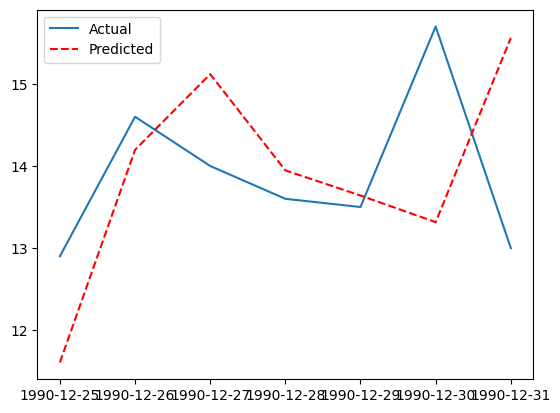

In [35]:

plt.plot(test_x, test_y, label="Actual") 
plt.plot(test_x, pred, color='red', linestyle='dashed', label="Predicted")  

plt.legend() 
plt.show() 